# 👖 Autoencoders on Fashion MNIST


In this notebook, we'll walk through the steps required to train your own autoencoder on the fashion MNIST dataset.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rich.progress import Progress

import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import v2

from notebooks.utils import display

## 0. Parameters


In [2]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    gpu_name = torch.cuda.get_device_name(0)
    print(f"Let's use CUDA ({gpu_name})")
else:
    device = torch.device('cpu')

Let's use CUDA (NVIDIA RTX 6000 Ada Generation)


## 1. Prepare the data


In [13]:
# Load the data
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Pad([2, 2, 2, 2], padding_mode='constant', fill=0.0),
    ]
)
train_set = datasets.FashionMNIST(root='data', train=True, download=True, transform=transforms)
test_set = datasets.FashionMNIST(root='data', train=False, download=True, transform=transforms)

In [14]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, persistent_workers=True
)

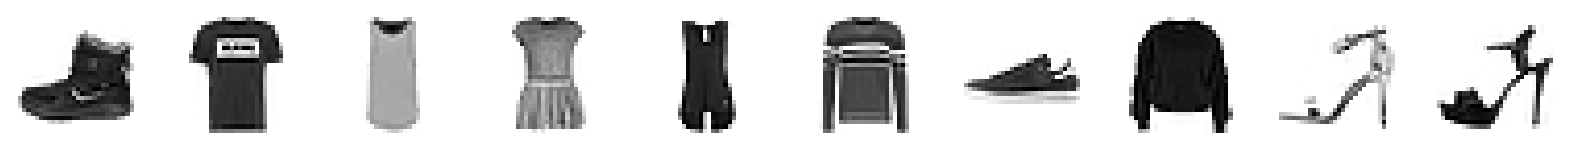

In [15]:
# Show some items of clothing from the training set
x_train = np.array([train_set[i][0] for i in range(10)])
display(x_train)

## 2. Build the autoencoder


In [7]:
# Encoder
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(CHANNELS, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, EMBEDDING_DIM),
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [8]:
# Decoder
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(EMBEDDING_DIM, 128 * 4 * 4),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, CHANNELS, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [9]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
train_parameters = list(encoder.parameters()) + list(decoder.parameters())
opt = torch.optim.Adam(train_parameters, lr=1.0e-3)

## 3. Train the autoencoder


In [10]:
with Progress() as progress:
    ema_loss = 0.0
    for epoch in range(EPOCHS):
        train_task = progress.add_task("Training...", total=len(train_loader))
        encoder.train()
        decoder.train()
        for X, _ in train_loader:
            X = X.to(device)
            z = encoder(X)
            X_hat = decoder(z)
            loss = F.binary_cross_entropy(X_hat, X)

            opt.zero_grad()
            loss.backward()
            opt.step()

            ema_loss = 0.9 * ema_loss + 0.1 * loss.item() if ema_loss else loss.item()
            progress.update(train_task, advance=1, description=f'[{epoch + 1}/{EPOCHS}] loss: {ema_loss:.4f}')

    progress.update(train_task, refresh=True)

Output()

## 4. Reconstruct using the autoencoder


In [16]:
n_to_predict = 5000
test_subset = torch.utils.data.Subset(test_set, np.arange(n_to_predict))
test_loader = torch.utils.data.DataLoader(
    test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, persistent_workers=True
)

In [42]:
avg_loss = 0.0
count = 0
example_images = []
example_labels = []
predictions = []

with Progress() as progress:
    test_task = progress.add_task('Testing...', total=len(test_loader))
    encoder.eval()
    decoder.eval()
    for X, y in test_loader:
        with torch.no_grad():
            X = X.to(device)
            z = encoder(X)
            X_hat = decoder(z)

        loss = F.binary_cross_entropy(X_hat, X)
        avg_loss += loss.item() * X.size(0)
        count += X.size(0)

        example_images.append(X.cpu().detach().numpy())
        example_labels.append(y.cpu().detach().numpy())
        predictions.append(X_hat.cpu().detach().numpy())

        progress.update(test_task, advance=1)

    avg_loss /= count
    example_images = np.concatenate(example_images, axis=0)
    predictions = np.concatenate(predictions, axis=0)

    progress.update(test_task, refresh=True)
    progress.console.log(f'[Test] loss: {avg_loss:.4f}')

Output()

[08:15:07] [Test] loss: 0.2590                                                                     ]8;id=194386;file:///tmp/ipykernel_21977/3662752878.py\3662752878.py]8;;\:]8;id=915814;file:///tmp/ipykernel_21977/3662752878.py#32\32]8;;\

Example real clothing items


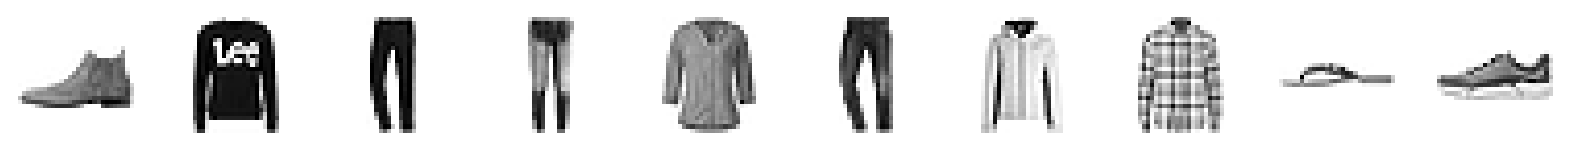

Reconstructions


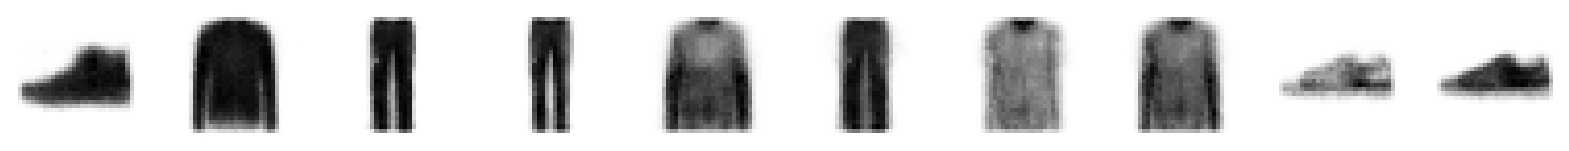

In [43]:
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)

## 5. Embed using the encoder


In [44]:
# Encode the example images
embeddings = []

with Progress() as progress:
    test_task = progress.add_task('Testing...', total=len(test_loader))
    encoder.eval()
    decoder.eval()
    for X, _ in test_loader:
        with torch.no_grad():
            X = X.to(device)
            z = encoder(X)

        embeddings.append(z.cpu().detach().numpy())
        progress.update(test_task, advance=1)

    embeddings = np.concatenate(embeddings, axis=0)
    progress.update(test_task, refresh=True)
    progress.console.log(f'[Test] loss: {avg_loss:.4f}')

Output()

[08:15:09] [Test] loss: 0.2590                                                                     ]8;id=969755;file:///tmp/ipykernel_21977/1897783401.py\1897783401.py]8;;\:]8;id=469078;file:///tmp/ipykernel_21977/1897783401.py#18\18]8;;\

In [45]:
# Some examples of the embeddings
print(embeddings[:10])

[[ -1.5927954   -4.885112  ]
 [ -0.93140584   1.39708   ]
 [ -9.554627     5.684633  ]
 [-10.525219     4.500175  ]
 [ -1.9674013    0.08324508]
 [ -5.4564695    3.1289074 ]
 [ -3.4047897    0.11158299]
 [ -2.5559893    0.21029596]
 [ -4.981168    -6.2473516 ]
 [ -4.164845    -7.512077  ]]


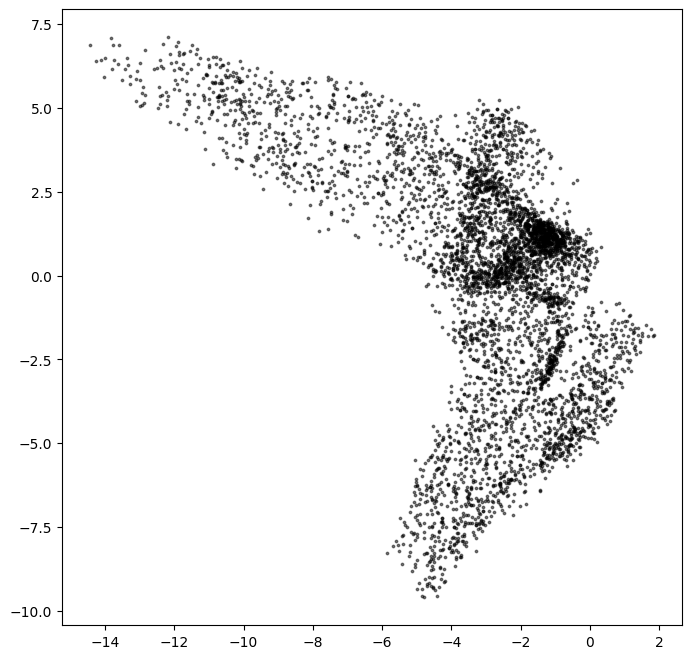

In [46]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='black', alpha=0.5, s=3)
plt.show()

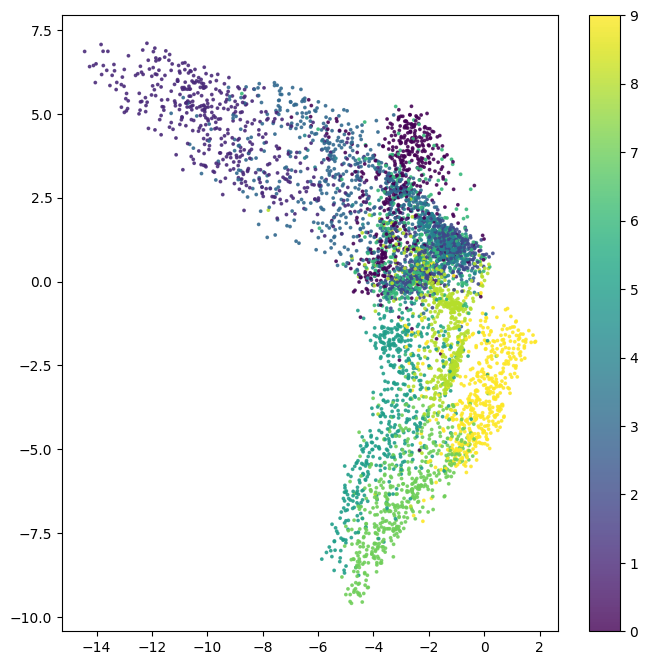

In [48]:
# Colour the embeddings by their label (colothing type - see table)
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=example_labels[:n_to_predict],
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

## 6. Generate using the decoder


In [53]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM))

In [54]:
# Decode the sampled points
sample_torch = torch.tensor(sample, dtype=torch.float32, device=device)
with torch.no_grad():
    reconstruction = decoder(sample_torch)

reconstruction = reconstruction.cpu().detach().numpy()

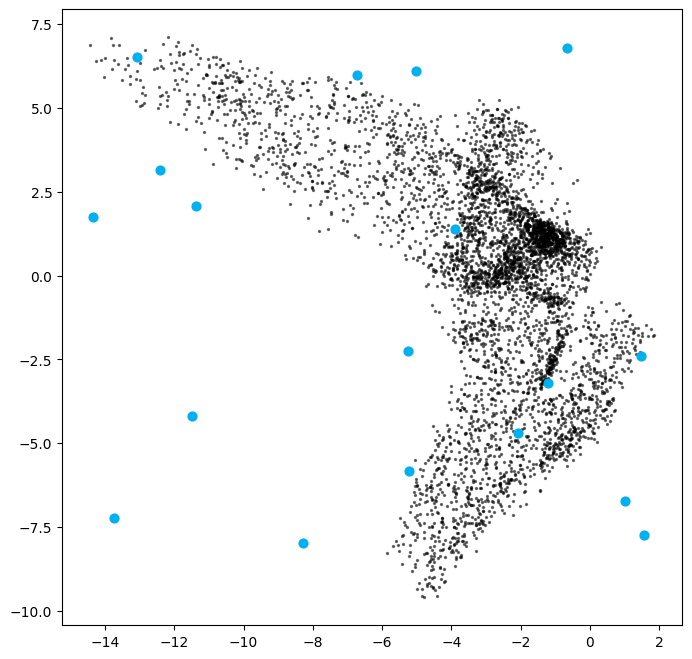

In [55]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='black', alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c='#00B0F0', alpha=1, s=40)
plt.show()

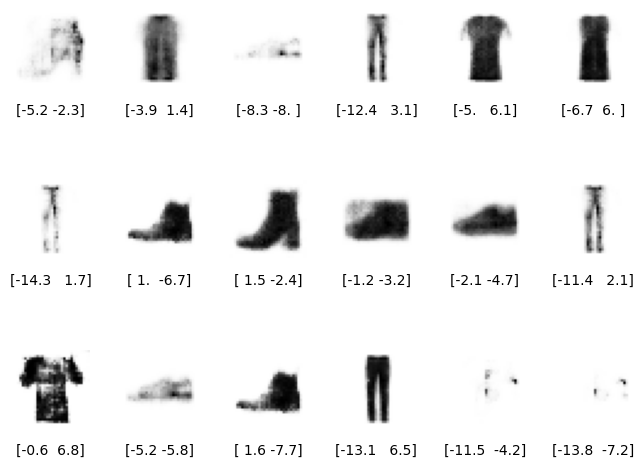

In [57]:
# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.imshow(reconstruction[i].squeeze(), cmap='gray')
    ax.axis('off')
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha='center',
        transform=ax.transAxes,
    )
    ax.imshow(reconstruction[i].squeeze(), cmap='Greys')

plt.show()